# Sentiment Analysis of Movie Reviews Using Deep Learning
Team Members: Mik Vattakandy, Aidan Sim

## Project Overview
    This project explores sentiment analysis using Natural Language Processing to classify text as expressing positive, negative, or neutral sentiment. The aim is to compare several machine learning models to eachother for sentiment analysis in order to see the differences between traditional models (TF-IDF with logistic regression) and deep learning models (LSTM)

In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Description

This Dataset (imdb_reviews) from tensorflow contains 50,000 total features, 25,000 movie reviews for training, and 25,000 for testing. The labels are the sentiment of each review, either labeled "positive" or "negative". The movie reviews featured in the dataset vary from positive movie reviews, to negative movie critiques, providing an ample and plentiful amount of training data for the models.

### Dataset Preprocessing

The code segment below imports the dataset, and then cleans the values within (the reviews) and also converts the sentiment values to being 1, for positive sentiment, and 0, for negative sentiment. The reviews need to be cleaned as some of them contain HTML tags, punctuation, and other symbols and characters that would be problematic for the models to run on.

In [5]:
#Dataset Cleaning and processing
df = pd.read_csv("Data\IMDB_dataset.csv")

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower()

df['review_clean'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})

X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['label'], test_size=0.2, random_state=42)

#Loading GloVe into dictionary for LSTM Model

embeddings = {}
with open("Data/glove.6B.100d.txt", encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector =  np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector

Total Samples: 50000
Class Distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64
count    50000.000000
mean       229.718300
std        170.163881
min          6.000000
25%        126.000000
50%        172.000000
75%        278.000000
max       2455.000000
Name: review_length, dtype: float64


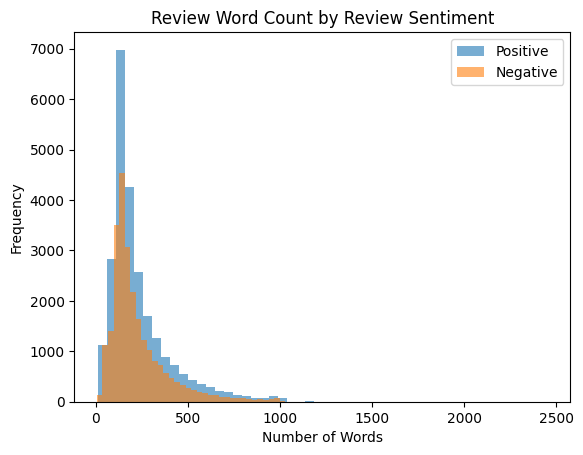

In [6]:
#Dataset Description
print(f"Total Samples: {len(df)}")
print(f"Class Distribution:\n{df['label'].value_counts(normalize=True)}")
df['review_length'] = df['review_clean'].apply(lambda x: len(x.split()))
print(df['review_length'].describe())

#Plotting
plt.hist(df[df.label==1]['review_length'], bins=50, alpha=0.6, label='Positive')
plt.hist(df[df.label==0]['review_length'], bins=50, alpha=0.6, label='Negative')
plt.legend()
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Review Word Count by Review Sentiment")
plt.show()

### TF-IDF Model

This is the baseline model for this project, this model works by scoring the words based on how frequently they appear inside of the reviews. This ranking can indicate whether or not words are important to the meaning and sentiment of a sentence by creating a TF-IDF score. This score is acquired by taking the words "term frequency" (how often the word appears) and multiplying it by the words "Inverse Document Frequency" (how rare the word is across all of the reviews). This works because words with high sentiment, words that convey a lot of emotion, are more rare across all of the reviews but are more frequent within the individual review thats positive. These scores are then put into a feature vector, which is then fed into a Linear Regression model in order to classify the reviews as having a positive, or negative sentiment.

In [7]:
#TF-IDF Model Code

#Vectorization
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Logistic Regression
start = time.time()
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
end = time.time()
y_pred_tfidf = clf.predict(X_test_tfidf)

tfidf_features = X_train_tfidf.shape[1]
tfidf_time = end - start

print(f"TF-IDF Model Accuracy: {accuracy_score(y_test, y_pred_tfidf)}\n{classification_report(y_test, y_pred_tfidf)}")
print(f"TF-IDF Features: {tfidf_features}")
print(f"TF-IDF Model Training Time: {end - start} seconds")

TF-IDF Model Accuracy: 0.9005
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

TF-IDF Features: 20000
TF-IDF Model Training Time: 0.5100281238555908 seconds


### LSTM Model

The LSTM (Long Short Term Memory) Model works by first loading the GloVe (Global Vectors for Word Representation) file into a dictionary, which is then turned into an embedding matrix that can be used by the model. Before the reviews can be put through the LSTM Model, the reviews must be "tokenized" which changes the reviews by seperating each word from the review, and the converting the resulting "tokens" into a sequences of numbers. The model is then prepared by loading the embedding matrix, along with the reviews. When the model is training, it builds an artificial memory of the words in the reviews (or as it sees it the numbers representative of words) to decide whether or not a word is fluff (such as "the" or "a") or if it has sentimental meaning. It also compares the words against the GloVe embedding matrix to analyse which words mean similar things (such as "amazing" and "fantastic") in order to build a stronger accuracy as to the sentiment of a review. This makes it so the model is predicting the reviews sentiment based off of patterns, instead of whether or not a specific word appears multiple times.

In [8]:
#LSTM Model Code
max_words = 20000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

#GloVe Embedding Matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

#Building LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    SpatialDropout1D(0.25),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.1, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
#LSTM Model Training
start = time.time()
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)
end = time.time()

lstm_time = end - start

lstm_loss, lstm_acc = model.evaluate(X_test_seq, y_test)
print(f"LSTM Model Accuracy: {lstm_acc}")
print(model.summary())
print(f"TF-IDF Model Training Time: {end - start} seconds")

Epoch 1/20


c:\Users\Sharp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 426s 848ms/step - accuracy: 0.7007 - loss: 0.5548 - val_accuracy: 0.8656 - val_loss: 0.3185
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 444s 888ms/step - accuracy: 0.8719 - loss: 0.3183 - val_accuracy: 0.8861 - val_loss: 0.2686
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 426s 851ms/step - accuracy: 0.9049 - loss: 0.2487 - val_accuracy: 0.8997 - val_loss: 0.2432
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 430s 861ms/step - accuracy: 0.9256 - loss: 0.2003 - val_accuracy: 0.9041 - val_loss: 0.2459
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 468s 936ms/step - accuracy: 0.9395 - loss: 0.1691 - val_accuracy: 0.9021 - val_loss: 0.2490
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 449s 899ms/step - accuracy: 0.9504 - loss: 0.1402 - val_accuracy: 0.8976 - val_loss: 0.3036
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9009 - loss: 0.2423
LSTM Model Accuracy: 0.9009000062942505


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 300, 100)         │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (64, 300, 100)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (64, 256)              │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,753,029 (25.76 MB)

 Trainable params: 2,251,009 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,502,020 (17.17 MB)

None
TF-IDF Model Training Time: 2643.760098218918 seconds


## Late Fusion Model
This model combines the power and strengths of the TF-IDF Model as well as the LSTM Model. This process works by training both models, and then taking their predicitons, and combining them, using the equation $p_{final} = w_1 * p_{lstm} + w_2 * p_{tf-idf}$, where $w_1$ and $w_2$ represent the weights given to the models (based off of their validation accuracy scores), and $p_{lstm}$ and $p_{tf-idf}$ represent the probabilities given by each model. In the event of a tie between the models (one predicting positive sentiment and the other predicting negative) the resulting prediction is given to the model with the higher validation accuracy.

In [9]:
##Late Fusion
tfidf_probs = clf.predict_proba(X_test_tfidf)[:,1]
lstm_probs = model.predict(X_test_seq).flatten()
fusion = (tfidf_probs + lstm_probs) / 2
fusion_pred = (fusion > 0.5).astype(int)
fusion_acc = accuracy_score(y_test, fusion_pred)

print(f"Late Fusion Model Accuracy: {fusion_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step
Late Fusion Model Accuracy: 0.9102


In [10]:
#Comparison Code
print(f"Accuracy Differential (TF-IDF - LSTM): {accuracy_score(y_test, y_pred_tfidf) - lstm_acc}")
print(f"TF-IDF val acc: {accuracy_score(y_test, y_pred_tfidf)}\nLSTM val acc: {lstm_acc}\nLate Fusion Combined Model val acc: {fusion_acc}")
print(f"TF-IDF Model Time: {tfidf_time}\nLSTM Model Time: {lstm_time}")
print(f"Time Differential (TF-IDF - LSTM): {tfidf_time - lstm_time}")
print(f"TF-IDF Parameter Count: {tfidf_features}\nLSTM Parameter Count: {model.count_params()}")

Accuracy Differential (TF-IDF - LSTM): -0.00040000629425052114
TF-IDF val acc: 0.9005
LSTM val acc: 0.9009000062942505
Late Fusion Combined Model val acc: 0.9102
TF-IDF Model Time: 0.5100281238555908
LSTM Model Time: 2643.760098218918
Time Differential (TF-IDF - LSTM): -2643.2500700950623
TF-IDF Parameter Count: 20000
LSTM Parameter Count: 2251009


## Analysis and Results

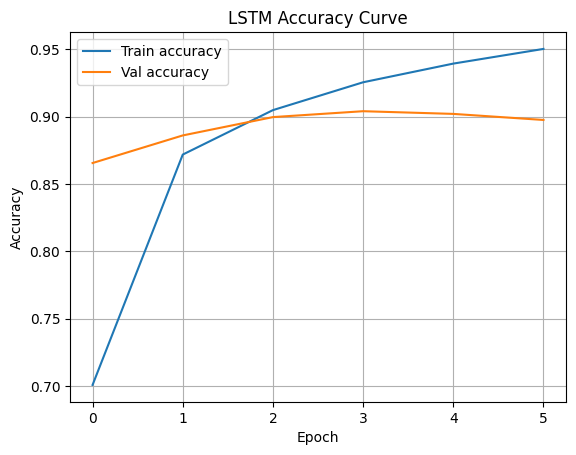

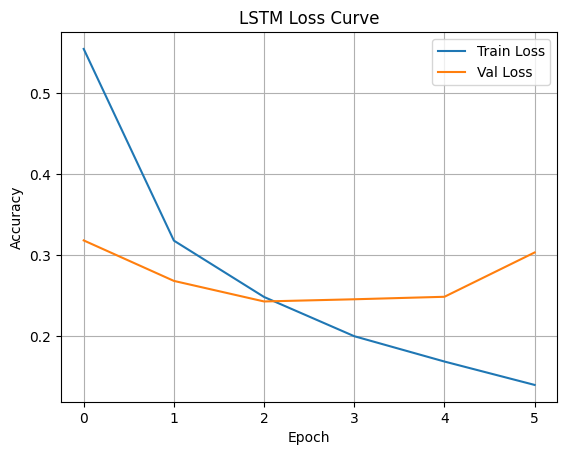

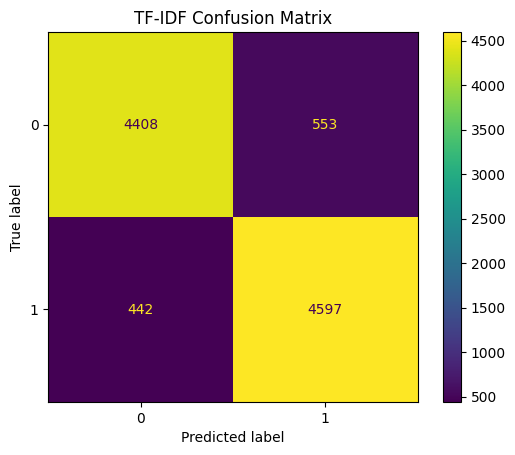

TF-IDF val acc: 0.9005
LSTM val acc: 0.9009000062942505
Late Fusion Combined Model val acc: 0.9102


In [11]:
#LSTM Accuracy
plt.plot(history.history['accuracy'], label="Train accuracy")
plt.plot(history.history['val_accuracy'], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

#LSTM Loss
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

#TF-IDF Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tfidf)
plt.title("TF-IDF Confusion Matrix")
plt.show()

print(f"TF-IDF val acc: {accuracy_score(y_test, y_pred_tfidf)}\nLSTM val acc: {lstm_acc}\nLate Fusion Combined Model val acc: {fusion_acc}")

The results gathered from training the above models demonstrate the differences in accuracy between the classical model (TF-IDF) and the more advanced deep learning model (LSTM). From the plots above, and the accuracies shown by the two different models, the TF-IDF model yielded an accuracy of 0.9005, whereas the LSTM Model (with GloVe) yielded an accuracy of 0.9009. This shows us that the accuracy increase between the LSTM Model and TF-IDF Model do not vary significantly. However, if we combine the two models utilizing the Late Fusion method, we can see a marked increase in the validation accuracy of the models, increasing the accuracy up to 0.9102. This works because the TF-IDF model and the LSTM model are both great at different things. The TF-IDF model excels at making accurate decisions off of short texts (where there is a lower frequency of repeated similar words), and its great at generalizing. The reason that the TF-IDF model excels at these things is because of how it functions, by comparing the frequency of words from one review against the entire dataset of reviews, it excels at analyzing the importance of a word in shorter text, because the likelyhood of different words (such as "great" and "good") that mean the same thing is lesser. Whereas the LSTM model excels at finding sequential patterns (even if the exact word, but same sentiment, appears), and at recognizing the context for larger texts. The reason that the LSTM model excels at this is due to its "tokenization" process and by its gating system. When the LSTM model looks at tokens, it assigns it 3 different values, "input", "forget", and "output". Depending on what status the token is assigned, the model will either add the new token, drop it, or pass it on to the next text, respectively. This allows for the model to remember context throughout the larger dataset, which helps improve its semantic understanding. The Late Fusion model combines these strengths without increasing the weaknesses, as the other model's strength is the base models weakness.

## File Sharing Repository

All Data (GloVe and imdb_dataset), along with jupyter notebook file can be found here

https://github.com/R11C3/CS345-Final-Project

## Team Member Contributions

Aidan Sim: File organization, code, dataset gathering and parsing, data analysis (plots and writing)

Mik Vattakandy: Project Proposal (was unresponsive to messages once work on project started and did not accept invitation to github repository)